In [80]:
import os
import argparse
import scipy.io
import numpy as np
import pickle as pkl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import neuralflow
from neuralflow.feature_complexity.fc_base import FC_tools
brain_region_list = ['left ALM', 'right ALM', 'left Medulla', 'right Medulla']

In [81]:
# ---------- Load Data ----------
brain_region = 'left ALM'  # 'left ALM', 'right ALM', 'left Medulla', 'right Medulla'
path = "../data/new_data_mini/session_057_aligned_spike_times.pkl"
with open(path, 'rb') as f:
    data_ori = pkl.load(f)
# 取出单个脑区数据
choice_list_all = ['LL', 'LR', 'RL', 'RR'] 
data = {}
for choice in choice_list_all:
    data[choice] = data_ori[choice][brain_region]

num_neurons_ori = len(data['RR']) # 假设所有条件的神经元数量相同

In [82]:
time_slot = (-1.2, 0.0) # 暂且固定
# ---------- Preprocessing ----------
# 预处理，截取时间段
for choice in choice_list_all:
    for neuron in range(num_neurons_ori):
        trial_counts = len(data[choice][neuron])
        for trial in range(trial_counts):
            spike_times = data[choice][neuron][trial]
            spike_times = spike_times[(spike_times >= time_slot[0]) & (spike_times <= time_slot[1])]
            data[choice][neuron][trial] = spike_times

# 预处理，如果一个trial中所有神经元都不发放，则需要把这个trial清洗掉
for choice in choice_list_all:
    valid_trials = []
    trial_counts = len(data[choice][0])  # 假定所有神经元trial_counts都一样
    for trial in range(trial_counts):
        valid = False
        for neuron in range(num_neurons_ori):
            spike_times = data[choice][neuron][trial]
            if len(spike_times) > 0:
                valid = True
                break  # 只要有一个神经元有spike就可以
        if valid:
            valid_trials.append(trial)
    # 只保留valid_trials对应的trial
    for neuron in range(num_neurons_ori):
        data[choice][neuron] = [data[choice][neuron][trial] for trial in valid_trials]

In [83]:
# 清洗出可以进入运算的神经元，清洗条件比较严格，要求每个choice下都的非空trial数量不少于20个
mini_batch_size = 20
choice_list_all = ['LL', 'LR', 'RL', 'RR'] 

non_zero_neurons = []
for neuron in range(num_neurons_ori):
    valid = True
    for choice in choice_list_all:
        spike_times = data[choice][neuron]
        non_empty_trials = sum(1 for trial in spike_times if len(trial) > 0)
        num_trials = len(spike_times)
        clean_thres = mini_batch_size if mini_batch_size < num_trials/2 else int(num_trials/2 - 1)
        if non_empty_trials < clean_thres:
            valid = False
            break
    if valid:
        non_zero_neurons.append(neuron)

data_cleaned = {choice: [data[choice][neuron] for neuron in non_zero_neurons] for choice in choice_list_all}
# 这边等会用文件记录一下

In [84]:
data_combined = [ [None]*len(non_zero_neurons), [None]*len(non_zero_neurons) ] # 两个条件，每个条件num_neurons个神经元
for neuron in range(len(data_cleaned['LL'])):
    combined_trials_L = data_cleaned['LL'][neuron] + data_cleaned['LR'][neuron]
    combined_trials_R = data_cleaned['RL'][neuron] + data_cleaned['RR'][neuron]
    data_combined[0][neuron] = combined_trials_L
    data_combined[1][neuron] = combined_trials_R

data_combined_array = []
for data_onechoice in data_combined:
    data_onechoice_array = np.array(data_onechoice, dtype=object)
    data_combined_array.append(data_onechoice_array)

In [85]:
data_1_list, data_2_list = [], []
for data_idx, data_onechoice in enumerate(data_combined_array):
    num_trials_onechoice = len(data_onechoice[0])  # Assuming all neurons have the same number of trials
    trial1 = np.arange(0, num_trials_onechoice, 2)
    trial2 = np.arange(1, num_trials_onechoice, 2)

    spiketimes1 = data_onechoice[:, trial1]
    timeepoch1 = [time_slot] * len(trial1)
    data_1 = neuralflow.SpikeData(
        data=spiketimes1, dformat='spiketimes', time_epoch=timeepoch1, with_cuda=True
    )
    data_1.change_format('ISIs')    

    spiketimes2 = data_onechoice[:, trial2]
    timeepoch2 = [time_slot] * len(trial2)
    data_2 = neuralflow.SpikeData(
        data=spiketimes2, dformat='spiketimes', time_epoch=timeepoch2, with_cuda=True
    )
    data_2.change_format('ISIs') 

    data_1_list.append(data_1)
    data_2_list.append(data_2)   

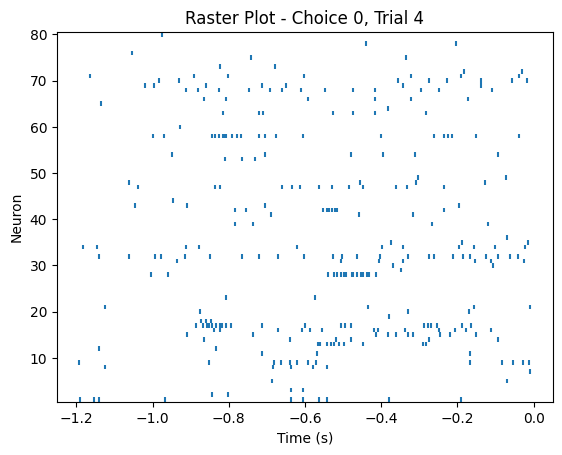

In [86]:
# plot raster for neurons in one trial
trial, choice = 4, 0

for neuron in range((data_combined_array[choice]).shape[0]):
    spike_times = data_combined_array[choice][neuron][trial]
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)
plt.ylim(0.5, (data_combined_array[choice]).shape[0] + 0.5)
plt.xlabel('Time (s)')
plt.ylabel('Neuron')
plt.title(f'Raster Plot - Choice {choice}, Trial {trial}')
plt.show()

# # plot raster for orginal data
# trial, choice = 7, 'RL'
# for neuron in range(len(data_ori[choice][brain_region])):
#     spike_times = data_ori[choice][brain_region][neuron][trial]
#     plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)
# plt.ylim(0.5, len(data_ori[choice][brain_region]) + 0.5)
# plt.xlabel('Time (s)')
# plt.ylabel('Neuron')
# plt.title(f'Raster Plot - Choice {choice}, Trial {trial}')
# plt.show()